In [537]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt
import dataframe_image as dfi

## Read in data and process it

In [2]:
# Read in data
co_raw_data = pd.read_csv("air_pollution_dataset/20221109 CO_CONC.txt")
nox_raw_data = pd.read_csv("air_pollution_dataset/20221109 NOX.txt")
o3_raw_data = pd.read_csv("air_pollution_dataset/20221109 O3_CONC.txt")
so2_raw_data = pd.read_csv("air_pollution_dataset/20221109 SO2.txt")

In [53]:
# Take a look at some of it, just to make sure it looks fine
nox_raw_data

# ... and it looks great!

,Date & Time (Local),Date & Time (UTC),NO Conc,NO2 Conc,NOX Conc
Date & Time (Local),,,,,
2022-11-02 00:00:00,11/02/2022 00:00:00,11/01/2022 16:00:00,0.025426,1.156407,1.181834
2022-11-02 00:01:00,11/02/2022 00:01:00,11/01/2022 16:01:00,0.228303,0.835713,1.064016
2022-11-02 00:02:00,11/02/2022 00:02:00,11/01/2022 16:02:00,0.271526,0.929296,1.200822
2022-11-02 00:03:00,11/02/2022 00:03:00,11/01/2022 16:03:00,0.253413,0.973889,1.227302
2022-11-02 00:04:00,11/02/2022 00:04:00,11/01/2022 16:04:00,0.229416,1.060475,1.289891
...,...,...,...,...,...
2022-11-09 23:55:00,11/09/2022 23:55:00,11/09/2022 15:55:00,-0.049756,2.738996,2.689240
2022-11-09 23:56:00,11/09/2022 23:56:00,11/09/2022 15:56:00,-0.069228,2.567157,2.497929
2022-11-09 23:57:00,11/09/2022 23:57:00,11/09/2022 15:57:00,-0.109956,2.518868,2.408912


> Just to make the generation of graphs easier a little later, I'll make a dictionary and add these four dataframes to it as values

In [18]:
raw_data = {'co': co_raw_data, 
            'nox': nox_raw_data,
            'o3':o3_raw_data,
            'so2': so2_raw_data}

# that should do it

### Data processing

##### Notice that the index column is numerical. Since this is time series data, it's better if we use the date as the indexs

In [182]:
# define a function to make this cleaner

def set_index_to_datetime(dataframe):
    """Takes in dataframe, and returns the datetime column as a datetime series"""
    return pd.to_datetime(dataframe["Date & Time (Local)"])

In [183]:
# now let's apply this to all the dataframes

dt_indexed_data = raw_data.copy()

for key in raw_data:
    dt_indexed_data[key].index = set_index_to_datetime(raw_data[key])

##### Also, now let's remove the Date and time columns (since the index takes care of this)

In [184]:
def remove_datetime_cols(dataframe):
    """Returns the dataframe with the datetime cols removed"""
    return dataframe.drop(['Date & Time (Local)',' Date & Time (UTC)'], errors='ignore', axis=1)

In [279]:
pure_data = dt_indexed_data.copy()
for key in dt_indexed_data:
    pure_data[key] = remove_datetime_cols(dt_indexed_data[key])

##### Lastly, convert all data to numerical data (some is still strings)

In [280]:
for key in pure_data:
    df = pure_data[key]
    for column in df.columns.to_list():
        df[column] = pd.to_numeric(df[column], errors='coerce')

In [356]:
pure_data['so2']   # Nice and clean!!!

,SO2 Concentration
Date & Time (Local),
2022-11-02 00:00:00,0.111398
2022-11-02 00:01:00,0.108030
2022-11-02 00:02:00,0.167676
2022-11-02 00:03:00,0.184256
2022-11-02 00:04:00,0.171178
...,...
2022-11-09 23:55:00,0.286779
2022-11-09 23:56:00,0.282031
2022-11-09 23:57:00,0.291022


### This data probably also has many outliers, so let's remove any data points that lie outside of 3 standard deviations

In [282]:
# Let's find the mean, sd, max, min for each pollutant
def print_parameters(dataframe):
    """Takes in a dataframe and prints SD for each data column in it"""
    for column in dataframe.columns.to_list():
        sd = dataframe[column].std()
        mean = dataframe[column].mean()
        max_value = max(dataframe[column])
        min_value = min(dataframe[column])
        print(f"""{column}
            standard deviation: {sd}
            mean: {mean}
            max: {max_value}
            min: {min_value}\n""")

In [658]:
pure_data

{'co':                       CO Concentration
 Date & Time (Local)                   
 2022-11-02 00:00:00           0.193776
 2022-11-02 00:01:00           0.202965
 2022-11-02 00:02:00           0.134113
 2022-11-02 00:03:00           0.056784
 2022-11-02 00:04:00           0.141063
 ...                                ...
 2022-11-09 23:55:00           0.025967
 2022-11-09 23:56:00           0.071123
 2022-11-09 23:57:00           0.103921
 2022-11-09 23:58:00           0.125236
 2022-11-09 23:59:00           0.046849
 
 [11520 rows x 1 columns],
 'nox':                       NO Conc   NO2 Conc   NOX Conc
 Date & Time (Local)                                
 2022-11-02 00:00:00  0.025426   1.156407   1.181834
 2022-11-02 00:01:00  0.228303   0.835713   1.064016
 2022-11-02 00:02:00  0.271526   0.929296   1.200822
 2022-11-02 00:03:00  0.253413   0.973889   1.227302
 2022-11-02 00:04:00  0.229416   1.060475   1.289891
 ...                       ...        ...        ...
 2022-11-09 23

In [283]:
for key in pure_data:
    df = pure_data[key]
    print_parameters(df)

 CO Concentration
            standard deviation: 1.4396094527598602
            mean: 0.34924670364364435
            max: 40.5505027770996
            min: -0.501277923583984

 NO Conc
            standard deviation: 22.572727725829488
            mean: 7.05868039067831
            max: 400.435852050781
            min: -0.433141052722931

 NO2 Conc
            standard deviation: 8.413889573225333
            mean: 8.530331302712181
            max: 163.331512451172
            min: -6.01585340499878

 NOX Conc
            standard deviation: 26.033292152392846
            mean: 15.589024721833711
            max: 401.363586425781
            min: -2.52420520782471

 O3 Concentration
            standard deviation: 18.138063702241624
            mean: 25.72161394277456
            max: 396.336029052734
            min: -4.58027076721191

 SO2 Concentration
            standard deviation: 29.977970393363126
            mean: 2.79150457565988
            max: 400.116058349609
        

#### to see if it's possible to eliminate outliers using the standard deviation, let's check the distributions of the pollutant concentrations

In [293]:
def make_histogram_plot(column, column_label):
    plt.figure(figsize = (10, 5))
    
    plt.title(f'{column_label} Distribution')
    
    plt.hist(column, bins='auto')
    plt.show()

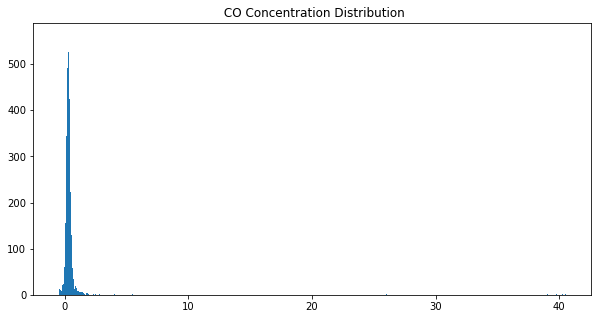

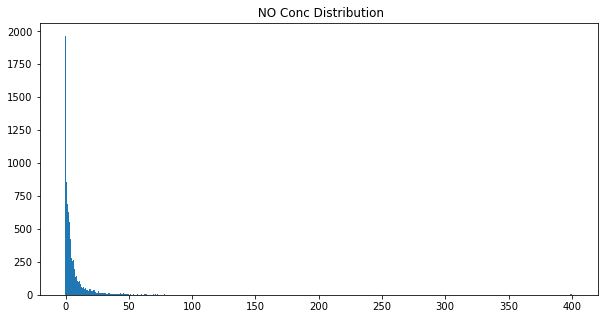

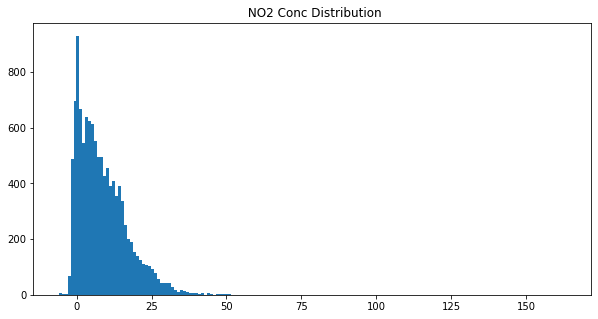

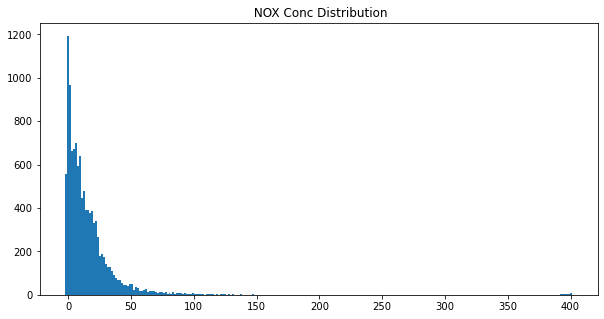

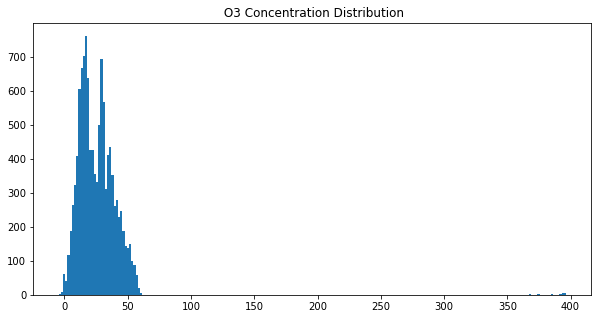

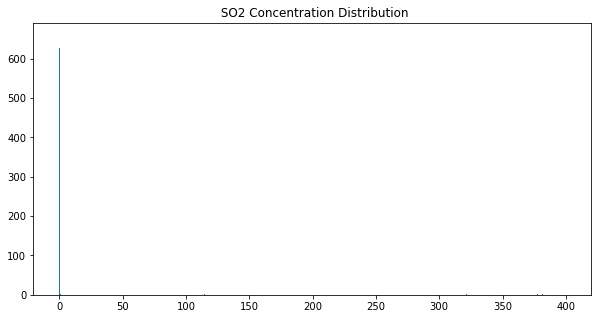

In [295]:
for key in pure_data:
    df = pure_data[key]
    for column in df.columns.to_list():
        make_histogram_plot(df[column], column)

Since the data for the most part doesn't appear to be normally distributed, I will use a method of excluding outliers based on the upper and lower quantiles

In [322]:
def make_boxplot(column, column_label):
    """makes boxplot for provided data column"""
    plt.figure(figsize =(20,5))
    
    plt.title(f'{column_label} boxplot')
    sns.boxplot(x=column)
    plt.show()

In [323]:
def apply_func_to_all_data_columns(func, data):
    for key in data:
        for column in data[key].columns.to_list():
            func(data[key][column], column)

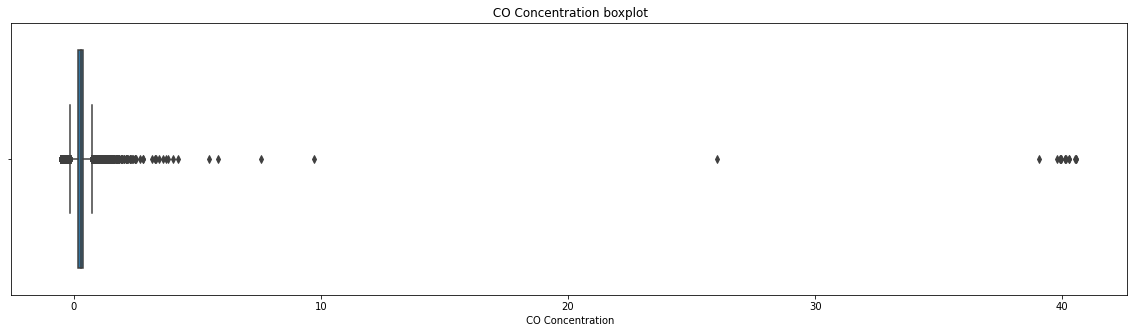

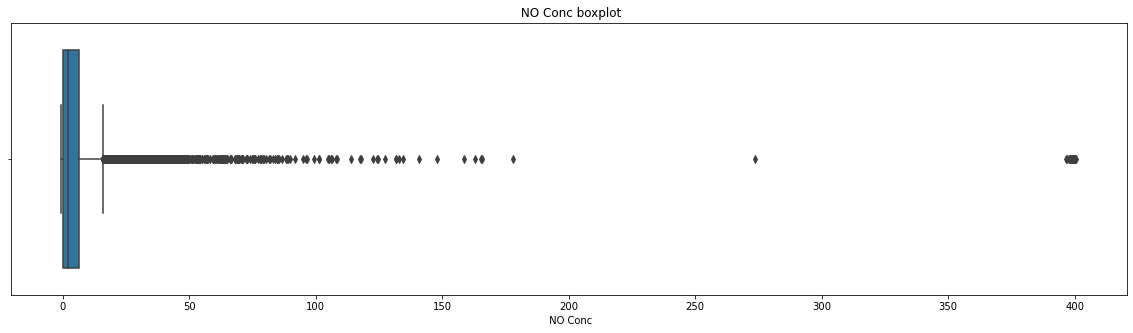

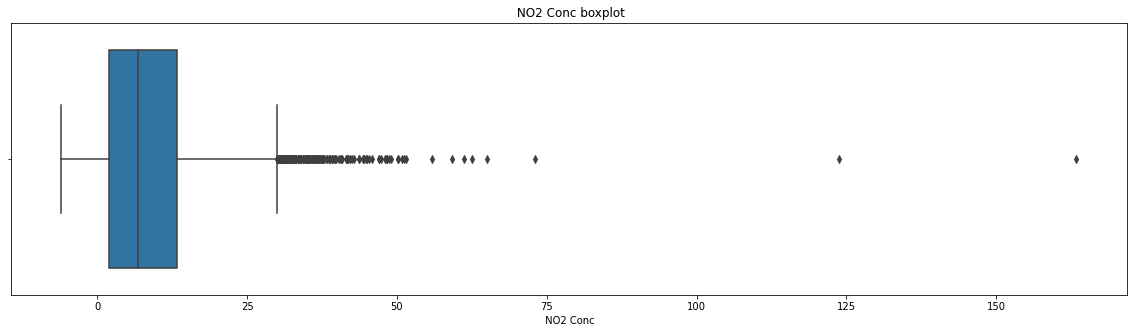

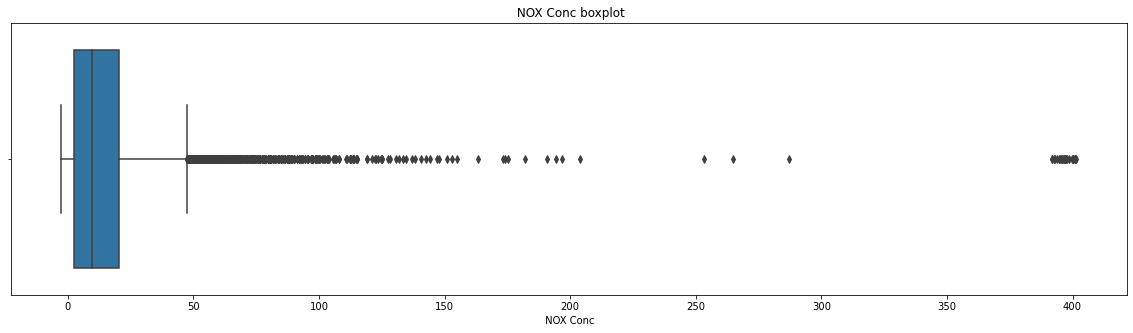

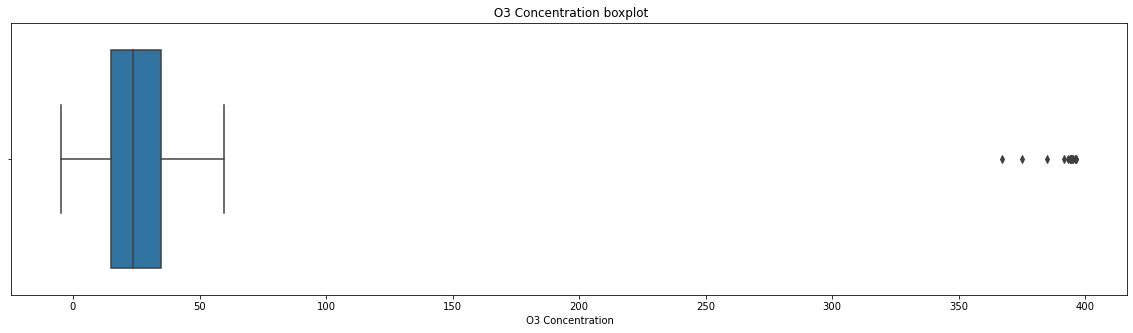

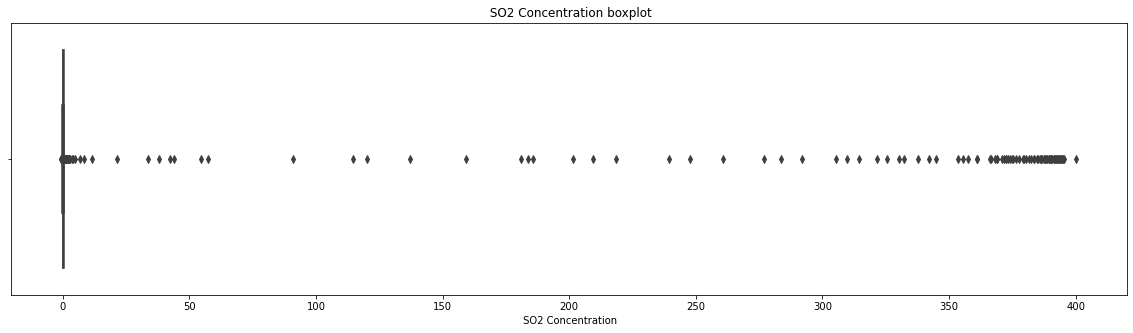

In [324]:
apply_func_to_all_data_columns(make_boxplot, pure_data)

The above boxplots just provide another method to visualise the distributions. It's clear that all the pollutant data has many outliers that fall far outside the interquartile range

In [386]:
def get_column_without_outliers(column):
    """returns the data column with outliers removed"""
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    
    filter = (column > Q1 - 1.5*IQR) & (column < Q3 + 1.5*IQR)
    return column[filter]

In [405]:
pure_data['co'].columns

Index([' CO Concentration'], dtype='object')

In [416]:
filtered_data = {
    'co' : get_column_without_outliers(pure_data['co'][' CO Concentration']).to_frame(),
    'so2': get_column_without_outliers(pure_data['so2'][' SO2 Concentration']).to_frame(),
    'o3': get_column_without_outliers(pure_data['o3'][' O3 Concentration']).to_frame(),
    'nox': get_column_without_outliers(pure_data['nox'][' NOX Conc']).to_frame(),
    'no': get_column_without_outliers(pure_data['nox'][' NO Conc']).to_frame(),
    'no2': get_column_without_outliers(pure_data['nox'][' NO2 Conc']).to_frame()
}

### Initial time series plot - weeklong plot

In [470]:
# lets add a rolling average of a 30 minute period for the data
window_size = 90
for key in filtered_data:
    for col in filtered_data[key].columns.to_list():
        if 'conc' in col.lower():
            filtered_data[key][f'{key} SMA {window_size}  min'] = filtered_data[key][col].rolling(window_size).mean()

In [471]:
filtered_data['co'].columns    # rolling average starts from 30th value (30 min mark)

Index([' CO Concentration', 'co SMA 30  min', 'co SMA 60  min',
       'co SMA 120  min', 'co SMA 90  min'],
      dtype='object')

##### Plotting time series data for every data column

In [474]:
def make_time_series_plot(dataframe):
    for column in dataframe.columns.to_list():
        if '120' in column:
            # labels 
            ylabel = column.split(' ')[0].upper()
            window = column.split(' ')[2]
            title = f'{ylabel} Concentration Time Series Data ({window} min SMA)'
            plt.figure(figsize = (20, 12))
            plt.title(title)
            plt.ylabel(f'{ylabel} Concentration (pbb)')
            plt.xlabel('Date')
            
            plt.plot(dataframe[column])
            plt.savefig(title )
            plt.show()

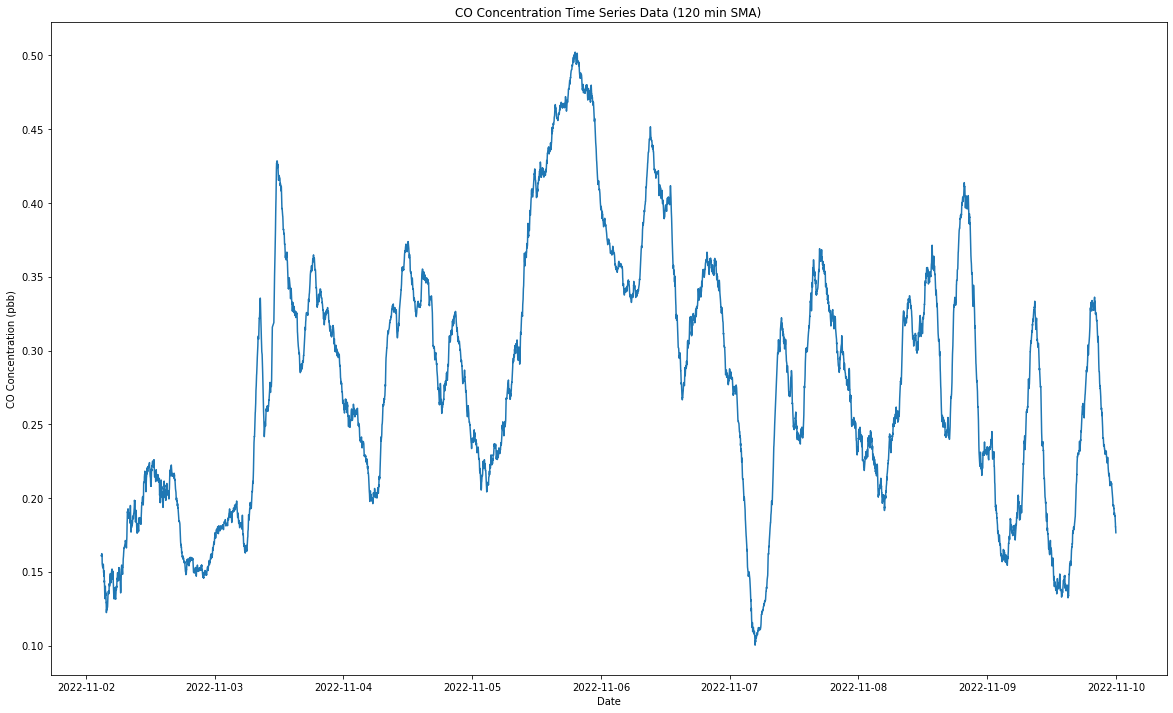

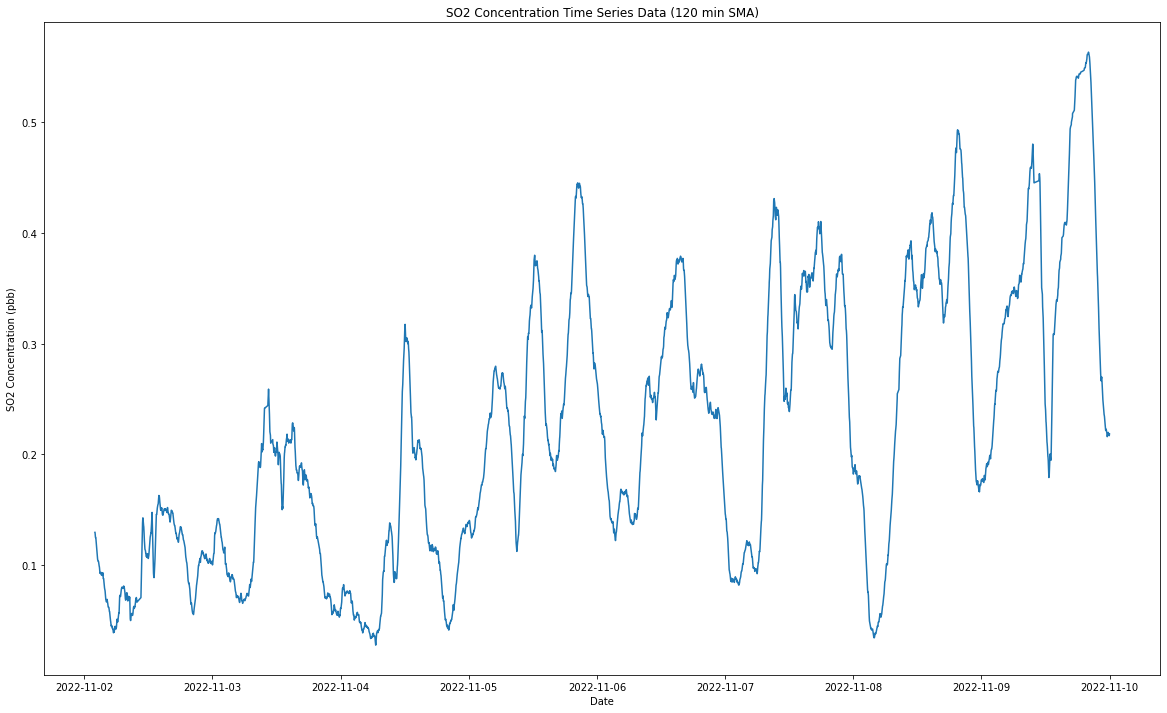

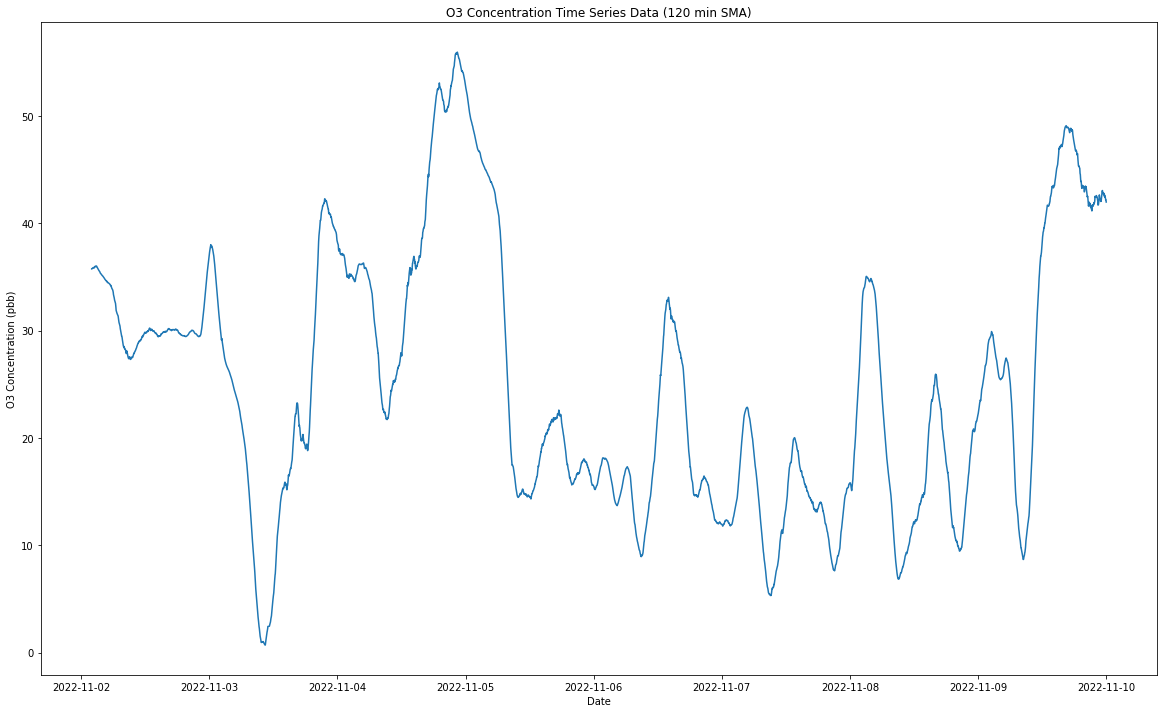

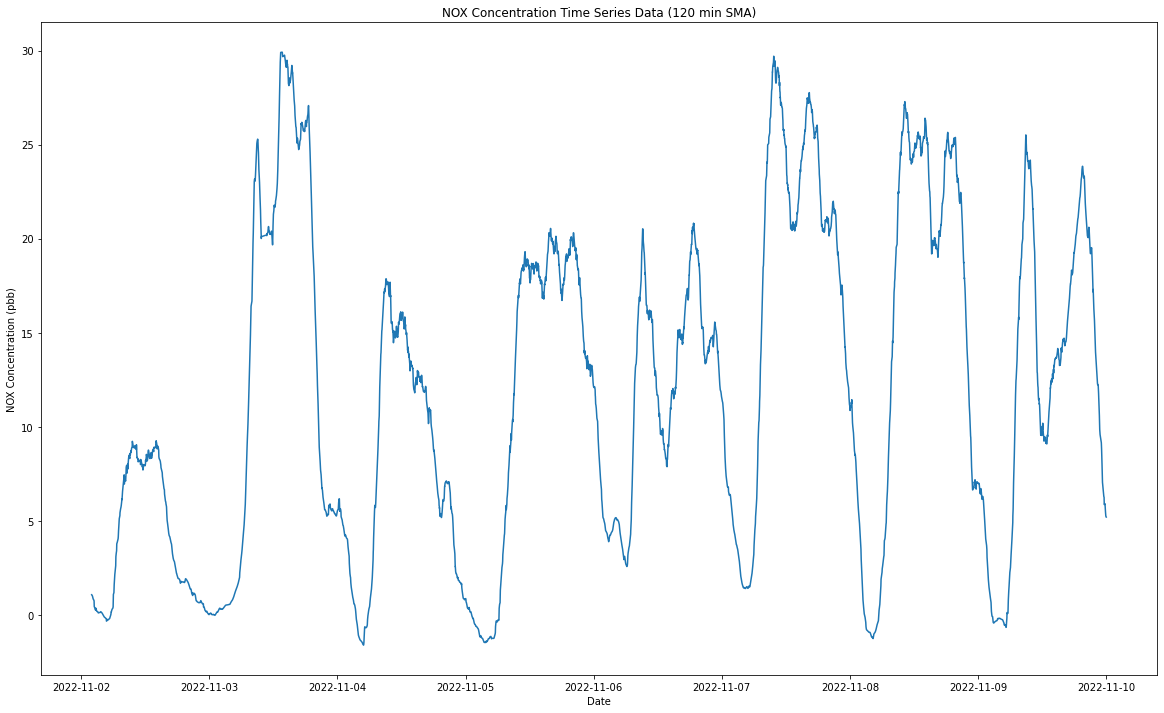

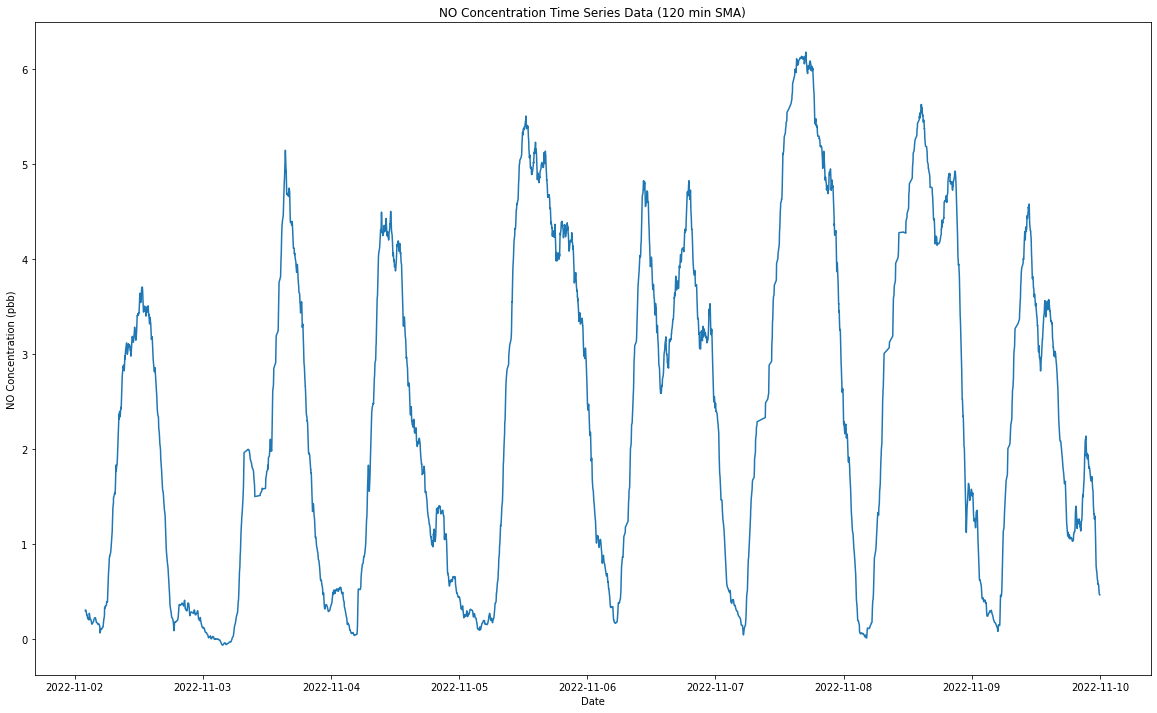

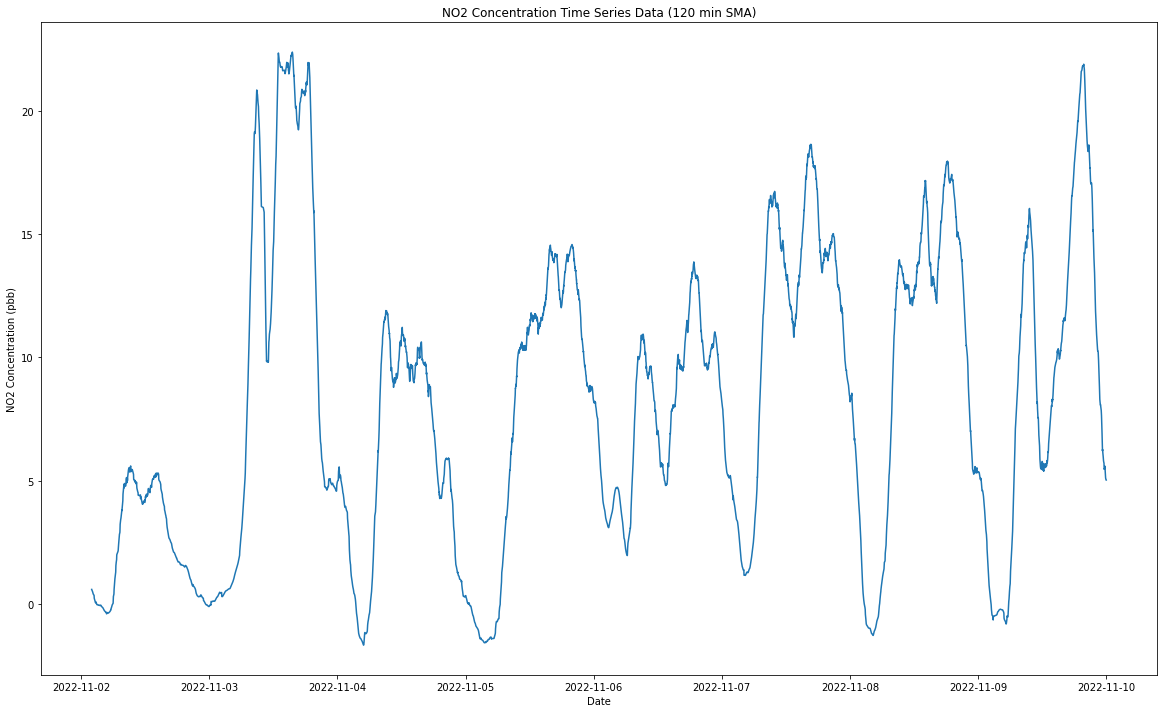

In [476]:
for key in filtered_data:
    df = filtered_data[key]
    make_time_series_plot(df)

#### calculate daily averages and save that table

In [517]:
# All unique dates
dates = np.unique(filtered_data['co'][' CO Concentration'].index.date)
dates

array([datetime.date(2022, 11, 2), datetime.date(2022, 11, 3),
       datetime.date(2022, 11, 4), datetime.date(2022, 11, 5),
       datetime.date(2022, 11, 6), datetime.date(2022, 11, 7),
       datetime.date(2022, 11, 8), datetime.date(2022, 11, 9)],
      dtype=object)

In [518]:
def get_daily_averages(column):
    daily_avgs = []
    date_change_indexes = []
    for date in dates:
        date_filter = column.index.date == date
        daily_avgs.append(column[date_filter].mean())
    return daily_avgs

In [544]:
daily_avg_data = {}
for key in filtered_data:
    df = filtered_data[key]
    for column in df.columns.to_list():
        if 'SMA' not in column:
            daily_avg_data.update({key.upper(): get_daily_averages(df[column])})

In [545]:
daily_avg_df = pd.DataFrame(daily_avg_data, index=dates)
m

,CO,SO2,O3,NOX,NO,NO2
2022-11-02,0.174575,0.102310,31.387910,3.746592,1.301923,2.217052
2022-11-03,0.283680,0.133066,22.286903,13.298992,1.496893,10.828820
2022-11-04,0.287948,0.113905,38.861345,7.489772,1.672296,5.398025
2022-11-05,0.380077,0.265732,24.774105,11.594653,2.694735,7.794602
2022-11-06,0.352000,0.234522,17.931854,11.637927,2.650589,7.839033
2022-11-07,0.248210,0.265970,13.722575,16.321729,2.909166,10.947582
2022-11-08,0.290488,0.269354,18.909536,14.484363,2.436835,9.419601
2022-11-09,0.213573,0.342440,34.309403,11.685786,1.796828,8.900502


In [547]:
dfi.export(daily_avg_df, 'daily_avg_data.png', dpi=200)

objc[30909]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb607dcec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/107.0.5304.110/Libraries/libGLESv2.dylib (0x112bfaed8). One of the two will be used. Which one is undefined.
[1128/193009.215977:INFO:headless_shell.cc(657)] Written to file /var/folders/tp/5nd54kxd7ns8b0xl8y88v1540000gn/T/tmpk7glyj7d/temp.png.


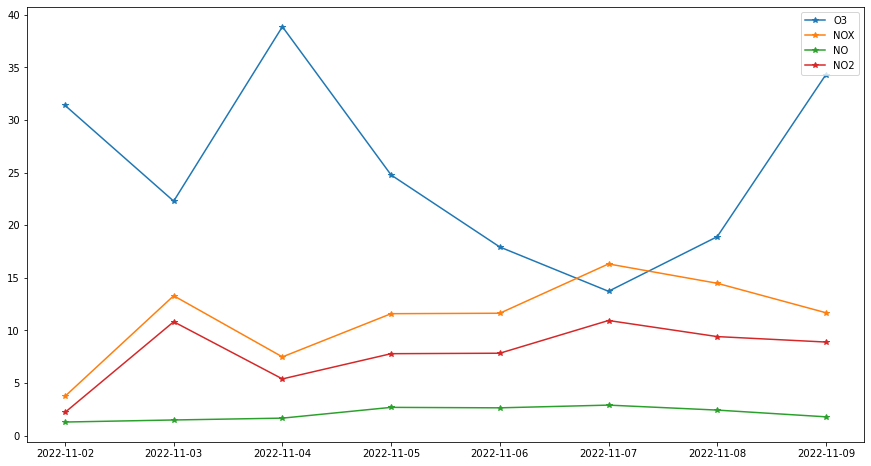

In [578]:
plt.figure(figsize=(15,8))
plt.plot(daily_avg_df[['O3','NOX', 'NO', 'NO2']], marker='*', label=[x for x in daily_avg_df.columns.to_list() if x not in ['CO', 'SO2']])
plt.legend(loc='upper right')
plt.show()
plt.savefig("")

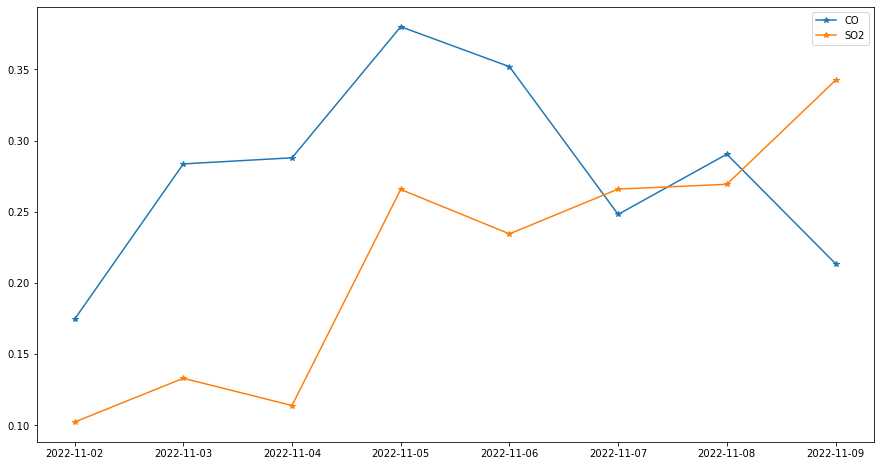

In [576]:
plt.figure(figsize=(15,8))
plt.plot(daily_avg_df[['CO', 'SO2']], marker='*', label=[x for x in daily_avg_df.columns.to_list() if x in ['CO', 'SO2']])
plt.legend(loc='upper right')
plt.show()

,O3 Concentration,o3 SMA 30 min,o3 SMA 60 min,o3 SMA 120 min,o3 SMA 90 min
Date & Time (Local),,,,,
2022-11-02 00:00:00,35.700905,NaN,NaN,NaN,NaN
2022-11-02 00:01:00,35.567810,NaN,NaN,NaN,NaN
2022-11-02 00:02:00,35.192345,NaN,NaN,NaN,NaN
2022-11-02 00:03:00,34.819950,NaN,NaN,NaN,NaN
2022-11-02 00:04:00,36.021713,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2022-11-09 23:55:00,43.469563,40.611526,41.107122,42.193516,41.883311
2022-11-09 23:56:00,41.836460,40.595221,41.108813,42.182164,42.053220
2022-11-09 23:57:00,42.135880,40.563851,41.055114,42.131044,42.114555


In [606]:
date_filter = filtered_data['o3'][' O3 Concentration'].index.date == dates[3]
filtered_data['o3'][' O3 Concentration'][date]

Date & Time (Local)
2022-11-05 00:00:00    50.373508
2022-11-05 00:01:00    49.829346
2022-11-05 00:02:00    49.282730
2022-11-05 00:03:00    49.817043
2022-11-05 00:04:00    50.195885
                         ...    
2022-11-05 23:55:00    18.132338
2022-11-05 23:56:00    18.238539
2022-11-05 23:57:00    18.906672
2022-11-05 23:58:00    18.741970
2022-11-05 23:59:00    18.714375
Name:  O3 Concentration, Length: 1440, dtype: float64

In [687]:
lsts = []

for date in dates:
    date_filter = pure_data['co'][' CO Concentration'].index.date == date
    lsts.append(pure_data['co'][' CO Concentration'][date_filter])

In [688]:
a = lst[0]
for lst in lsts[1::]:
    a += lst.values
    
values = a/len(lsts)

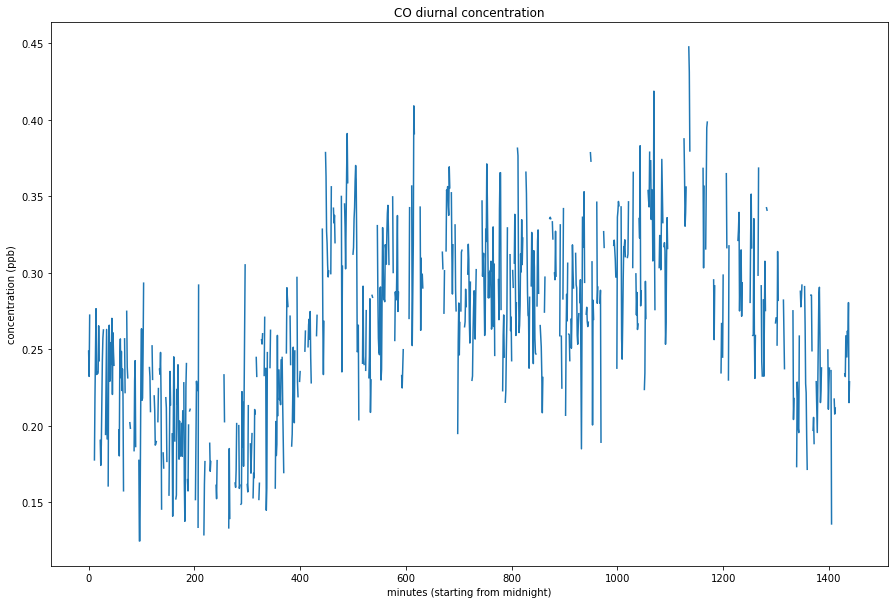

In [689]:
plt.figure(figsize=(15,10))
plt.plot(values)
title = 'CO diurnal concentration'
plt.title(title)
plt.xlabel('minutes (starting from midnight)')
plt.ylabel('concentration (ppb)')

plt.savefig(title)
plt.show()